In [1]:
import pandas as pd
import numpy as np
import scipy
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import re
import sys

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
data_call = pd.read_csv('data_call.csv')
optimized_parameter_call = pd.read_csv('optimized_parameter_call.csv')

In [4]:
optimized_parameter_call

,Unnamed: 0,a,b,rho,m,sigma
0,2024-08-05,0.148221,23.577903,-0.327093,0.002299,0.009105
1,2024-08-06,-5.576093,23.337825,-0.233592,-0.033364,0.251937
2,2024-08-07,-8.556918,48.791174,-0.745606,-0.262945,0.266575
3,2024-08-08,-17.965607,39.662779,-0.518746,-0.278983,0.532509
4,2024-08-09,-2.502966,11.709369,-0.456217,-0.075693,0.248100
5,2024-08-13,-1.112441,5.315842,-0.100365,0.038913,0.219831
6,2024-08-14,-0.283881,2.896253,-0.414731,0.003440,0.127423
7,2024-08-15,-4.456024,10.456148,0.292599,0.200556,0.450679
8,2024-08-16,-57.720858,27.864677,-0.507652,-1.312028,2.406249
9,2024-08-19,-0.622467,3.613184,0.335964,0.139377,0.194233


In [5]:
# SVI 모델 함수 정의
def svi_model(k, a, b, rho, m, sigma):
    return a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma**2))

# log-moneyness(k)의 범위 설정 (적절한 범위로 조정 가능)
k_values = np.linspace(-1, 1, 100)

# 각 만기일별로 implied volatility를 저장할 리스트 생성
implied_volatility_results = []

# optimized_parameter에 있는 각 만기일별 파라미터로 implied volatility 계산
for _, row in optimized_parameter_call.iterrows():
    expiration = row['Unnamed: 0']
    params = row[['a', 'b', 'rho', 'm', 'sigma']].values
    
    # SVI 모델을 사용해 해당 만기일의 w(k) 계산
    w_k = svi_model(k_values, *params)
    
    # implied volatility는 w(k)의 제곱근
    implied_volatility = np.sqrt(w_k)
    
    # 결과 저장 (만기일, log-moneyness, implied volatility)
    implied_volatility_results.append(pd.DataFrame({
        'Expiration': expiration,
        'Log-Moneyness': k_values,
        'Implied Volatility': implied_volatility
    }))

# 각 만기일별 결과를 하나의 DataFrame으로 병합
implied_volatility_df = pd.concat(implied_volatility_results, ignore_index=True)

# 결과 출력
print(implied_volatility_df)


      Expiration  Log-Moneyness  Implied Volatility
0     2024-08-05      -1.000000            5.613485
1     2024-08-05      -0.979798            5.556898
2     2024-08-05      -0.959596            5.499728
3     2024-08-05      -0.939394            5.441958
4     2024-08-05      -0.919192            5.383568
...          ...            ...                 ...
3895  2026-12-18       0.919192            0.240410
3896  2026-12-18       0.939394            0.245377
3897  2026-12-18       0.959596            0.250357
3898  2026-12-18       0.979798            0.255348
3899  2026-12-18       1.000000            0.260346

[3900 rows x 3 columns]


/var/folders/br/wv_clq_j04qb0j90qb96j_c00000gn/T/ipykernel_12819/3863989300.py:20: RuntimeWarning: invalid value encountered in sqrt
  implied_volatility = np.sqrt(w_k)


In [6]:
# 실제 거래 데이터의 log-moneyness와 내재 변동성 가져오기
actual_volatility_df = data_call[['expiration', 'log_strike', 'implied_volatility']]

# 만기일별로 실제 내재 변동성과 SVI 모델 내재 변동성을 비교
comparison_results = []
for expiration in actual_volatility_df['expiration'].unique():
    # 해당 만기일 데이터 추출
    actual_data = actual_volatility_df[actual_volatility_df['expiration'] == expiration]
    model_data = implied_volatility_df[implied_volatility_df['Expiration'] == expiration]
    
    # 실제 거래된 log-moneyness에 대응하는 SVI 모델의 내재 변동성 찾기 (보간)
    model_volatility_interpolated = np.interp(
        actual_data['log_strike'].values, 
        model_data['Log-Moneyness'].values, 
        model_data['Implied Volatility'].values
    )
    
    # 결과 저장
    comparison_results.append(pd.DataFrame({
        'Expiration': expiration,
        'Log-Moneyness': actual_data['log_strike'].values,
        'Actual Implied Volatility': actual_data['implied_volatility'].values,
        'SVI Model Implied Volatility': model_volatility_interpolated
    }))

# 비교 결과 병합
comparison_df = pd.concat(comparison_results, ignore_index=True)

# 비교 결과 출력
print(comparison_df)


       Expiration  Log-Moneyness  Actual Implied Volatility  \
0      2024-08-05      -0.858200                     0.0000   
1      2024-08-05      -0.180162                     3.7412   
2      2024-08-05      -0.180592                     3.7454   
3      2024-08-05      -0.158103                     2.9431   
4      2024-08-05      -0.161430                     3.1269   
...           ...            ...                        ...   
48106  2026-12-18       0.410609                     0.1320   
48107  2026-12-18       0.410512                     0.1320   
48108  2026-12-18       0.410826                     0.1320   
48109  2026-12-18       0.512985                     0.1527   
48110  2026-12-18       0.622986                     0.1772   

       SVI Model Implied Volatility  
0                          5.203305  
1                          2.420478  
2                          2.423243  
3                          2.273579  
4                          2.296208  
...            

/Users/justhaji/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:565: RuntimeWarning: Method L-BFGS-B cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,
/var/folders/br/wv_clq_j04qb0j90qb96j_c00000gn/T/ipykernel_12819/663900195.py:51: RuntimeWarning: invalid value encountered in sqrt
  rmse = np.sqrt(np.mean((np.sqrt(w_actual) - np.sqrt(w_pred)) ** 2))



각 만기일별 SVI 모델 RMSE 비교
    Expiration      RMSE
0   2024-08-05  0.240940
1   2024-08-06  0.038936
2   2024-08-07  0.031144
3   2024-08-08  0.031850
4   2024-08-09  0.034022
5   2024-08-13  0.028135
6   2024-08-14  0.021789
7   2024-08-15  0.022207
8   2024-08-16  0.032884
9   2024-08-19  0.020926
10  2024-08-20  0.023612
11  2024-08-21  0.023192
12  2024-08-22  0.022988
13  2024-08-23  0.020930
14  2024-08-26  0.021632
15  2024-08-27  0.015022
16  2024-08-28  0.018742
17  2024-08-29  0.013522
18  2024-08-30  0.019631
19  2024-09-06  0.015749
20  2024-09-09  0.012751
21  2024-09-16  0.017431
22  2024-09-20       NaN
23  2024-09-27  0.014634
24  2024-09-30  0.015381
25  2024-10-18  0.012189
26  2024-10-31  0.013457
27  2024-11-15  0.009333
28  2024-11-29  0.021794
29  2024-12-20  0.012581
30  2025-01-17  0.011064
31  2025-03-21  0.006590
32  2025-03-31  0.008830
33  2025-05-16  0.006080
34  2025-06-20  0.006580
35  2025-07-18  0.004069
36  2025-09-19  0.003292
37  2025-12-19  0.006154
38

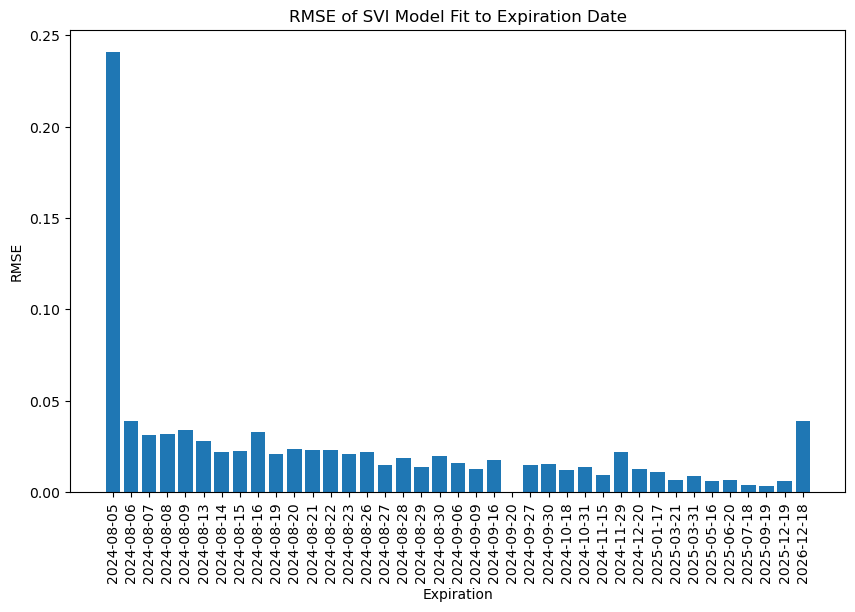

In [15]:
# data_call은 'expiration', 'log_strike', 'implied_volatility' 열이 포함된 DataFrame이어야 합니다.

# Step 1: SVI 모델 함수 정의
def svi_model(k, a, b, rho, m, sigma):
    return a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma**2))

# Step 2: 최적화에 사용할 목적 함수 정의
def objective_function(params, k, w_actual):
    a, b, rho, m, sigma = params
    w_pred = svi_model(k, a, b, rho, m, sigma)
    return np.sum((w_pred - w_actual) ** 2)

# Step 3: 파라미터의 경계 조건 및 제약식 설정
bounds = [(None, None), (0, None), (-1, 1), (None, None), (0, None)]
def rho_constraint(params):
    _, _, rho, _, _ = params
    return 1 - abs(rho)

constraints = [{'type': 'ineq', 'fun': rho_constraint}]

# Step 4: 초기 파라미터 추정값 설정
initial_params = [-0.041, 0.1331, 0.306, 0.3586, 0.4153]

# 총 분산 계산 (내재 변동성의 제곱)
data_call['w_actual'] = data_call['implied_volatility'] ** 2

# 고유한 만기일 추출
expiration_dates = data_call['expiration'].unique()

# 각 만기일의 최적화된 파라미터와 RMSE를 저장할 딕셔너리 생성
svi_params = {}
rmse_results = {}

for expiration in expiration_dates:
    subset = data_call[data_call['expiration'] == expiration]
    k = subset['log_strike'].values
    w_actual = subset['w_actual'].values
    
    # SVI 파라미터 최적화 수행
    result = minimize(objective_function, initial_params, args=(k, w_actual),
                      method='L-BFGS-B', bounds=bounds, constraints=constraints)
    
    # 최적화된 파라미터 저장
    params = result.x
    svi_params[expiration] = params
    
    # SVI 모델을 사용하여 예측된 분산 계산
    w_pred = svi_model(k, *params)
    
    # 실제 변동성과 예측 변동성의 RMSE 계산
    rmse = np.sqrt(np.mean((np.sqrt(w_actual) - np.sqrt(w_pred)) ** 2))
    rmse_results[expiration] = rmse

# Step 6: RMSE 결과를 DataFrame으로 표시
rmse_df = pd.DataFrame(list(rmse_results.items()), columns=['Expiration', 'RMSE'])
rmse_df = rmse_df.sort_values(by='Expiration')

# RMSE DataFrame 출력
print("\n각 만기일별 SVI 모델 RMSE 비교")
print(rmse_df)

# Step 7: (선택사항) 각 만기일별 RMSE 시각화
plt.figure(figsize=(10, 6))
plt.bar(rmse_df['Expiration'].astype(str), rmse_df['RMSE'])
plt.xlabel('Expiration')
plt.ylabel('RMSE')
plt.title('RMSE of SVI Model Fit to Expiration Date')
plt.xticks(rotation=90)
plt.show()


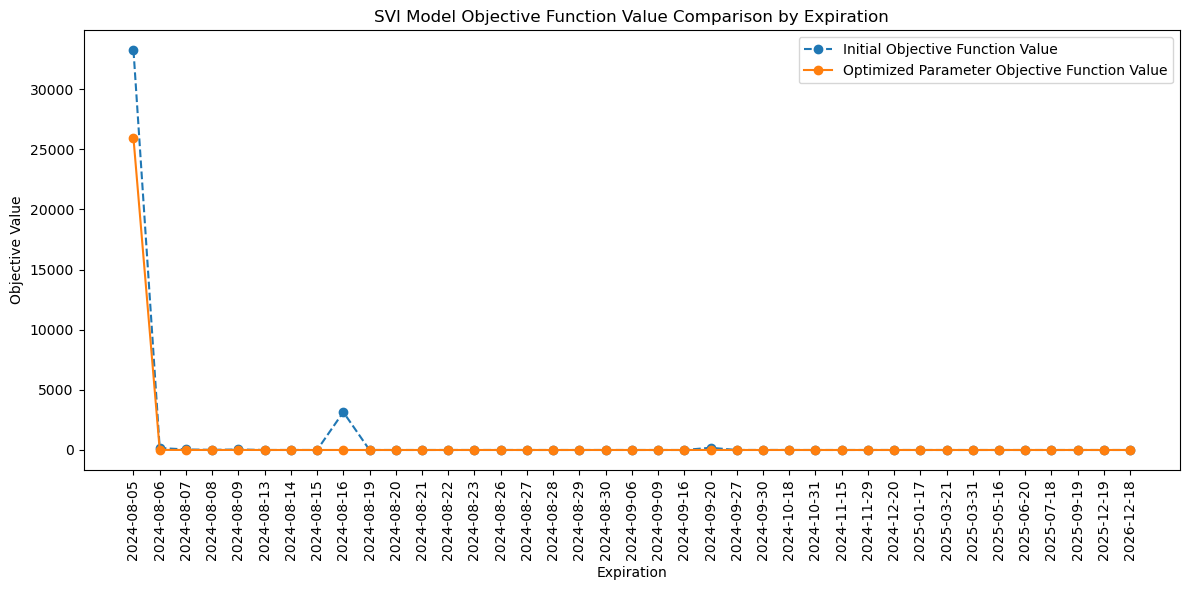

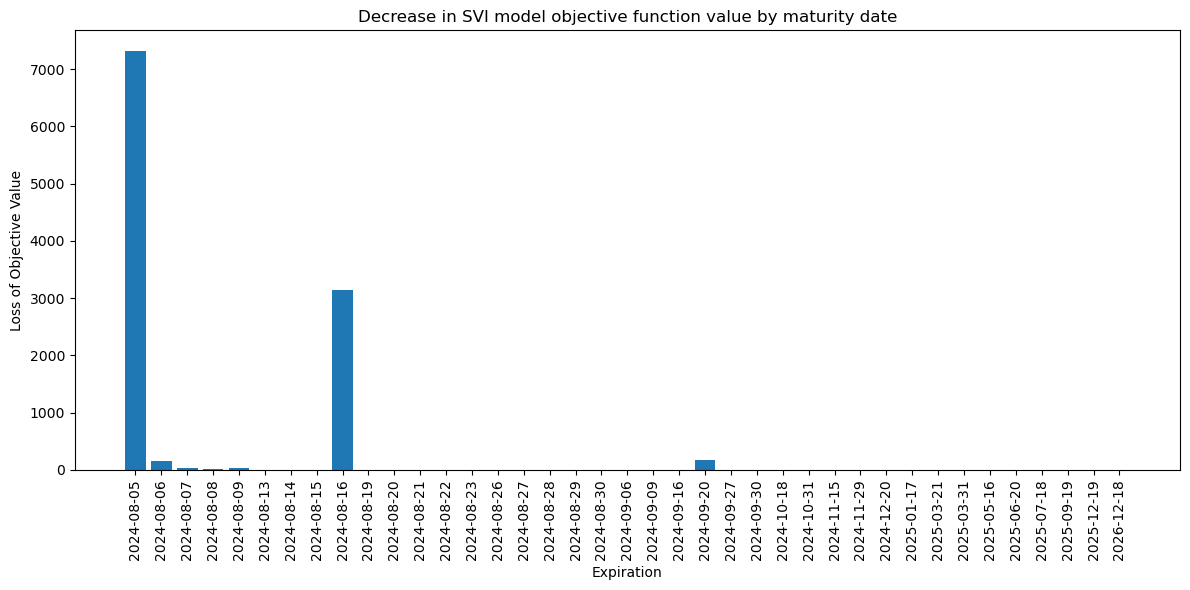

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Step 1: SVI 모델 함수 정의
def svi_model(k, a, b, rho, m, sigma):
    return a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma**2))

# Step 2: 목적 함수 정의
def objective_function(params, k, w_actual):
    a, b, rho, m, sigma = params
    w_pred = svi_model(k, a, b, rho, m, sigma)
    return np.sum((w_pred - w_actual) ** 2)

# Step 3: 초기 파라미터 설정
initial_params = [-0.041, 0.1331, 0.306, 0.3586, 0.4153]

# Step 4: 총 분산 계산 (내재 변동성의 제곱)
data_call['w_actual'] = data_call['implied_volatility'] ** 2

# Step 5: 최적화된 파라미터 불러오기
optimized_parameter = pd.read_csv('optimized_parameter.csv')

# Step 6: 만기일 추출
expiration_dates = data_call['expiration'].unique()

# 초기값과 최적화된 파라미터 사용 시의 목적 함수 값 비교를 저장할 딕셔너리
objective_values = {'expiration': [], 'initial_objective': [], 'optimized_objective': []}

for expiration in expiration_dates:
    subset = data_call[data_call['expiration'] == expiration]
    k = subset['log_strike'].values
    w_actual = subset['w_actual'].values
    
    # 초기 파라미터를 사용하여 목적 함수 값 계산
    initial_obj_value = objective_function(initial_params, k, w_actual)
    
    # 최적화된 파라미터 가져오기
    optimized_params = optimized_parameter[optimized_parameter['Unnamed: 0'] == expiration][['a', 'b', 'rho', 'm', 'sigma']].values.flatten()
    
    # 최적화된 파라미터를 사용하여 목적 함수 값 계산
    optimized_obj_value = objective_function(optimized_params, k, w_actual)
    
    # 결과 저장
    objective_values['expiration'].append(expiration)
    objective_values['initial_objective'].append(initial_obj_value)
    objective_values['optimized_objective'].append(optimized_obj_value)

# Step 7: 데이터프레임 생성
objective_df = pd.DataFrame(objective_values)

# Step 8: 초기 목적 함수 값 대비 최적화된 목적 함수 값의 감소량 시각화
plt.figure(figsize=(12, 6))
plt.plot(objective_df['expiration'], objective_df['initial_objective'], label='Initial Objective Function Value', marker='o', linestyle='--')
plt.plot(objective_df['expiration'], objective_df['optimized_objective'], label='Optimized Parameter Objective Function Value', marker='o', linestyle='-')
plt.xticks(rotation=90)
plt.xlabel('Expiration')
plt.ylabel('Objective Value')
plt.title('SVI Model Objective Function Value Comparison by Expiration')
plt.legend()
plt.tight_layout()
plt.show()

# Step 9: 목적 함수 값의 감소량 시각화
objective_df['reduction'] = objective_df['initial_objective'] - objective_df['optimized_objective']

plt.figure(figsize=(12, 6))
plt.bar(objective_df['expiration'].astype(str), objective_df['reduction'])
plt.xticks(rotation=90)
plt.xlabel('Expiration')
plt.ylabel('Loss of Objective Value')
plt.title('Decrease in SVI model objective function value by maturity date')
plt.tight_layout()
plt.show()


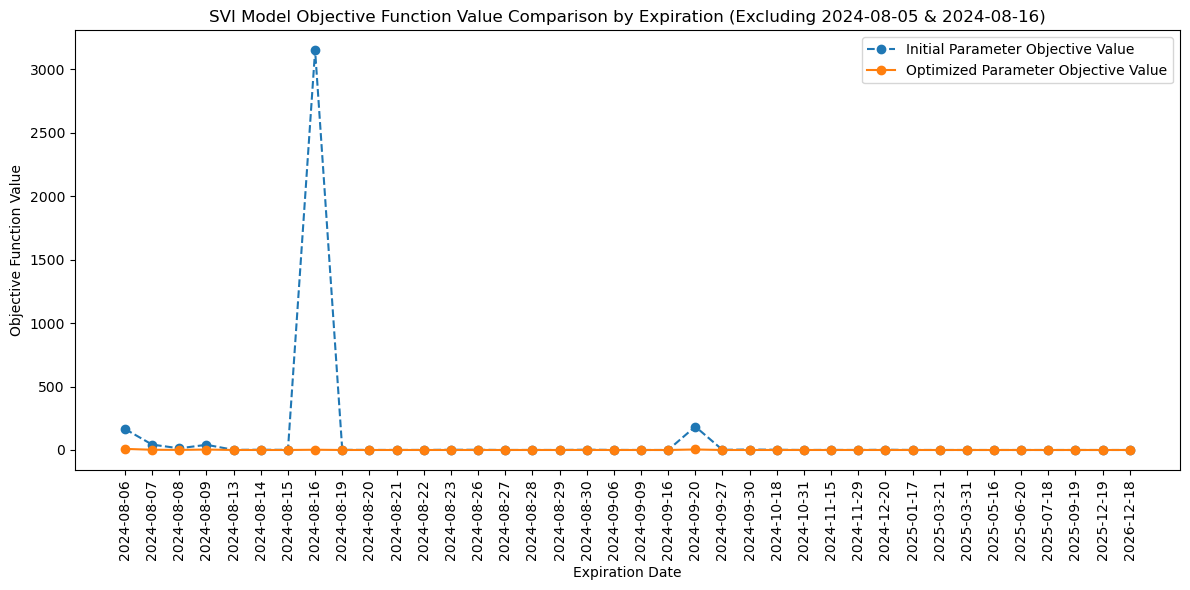

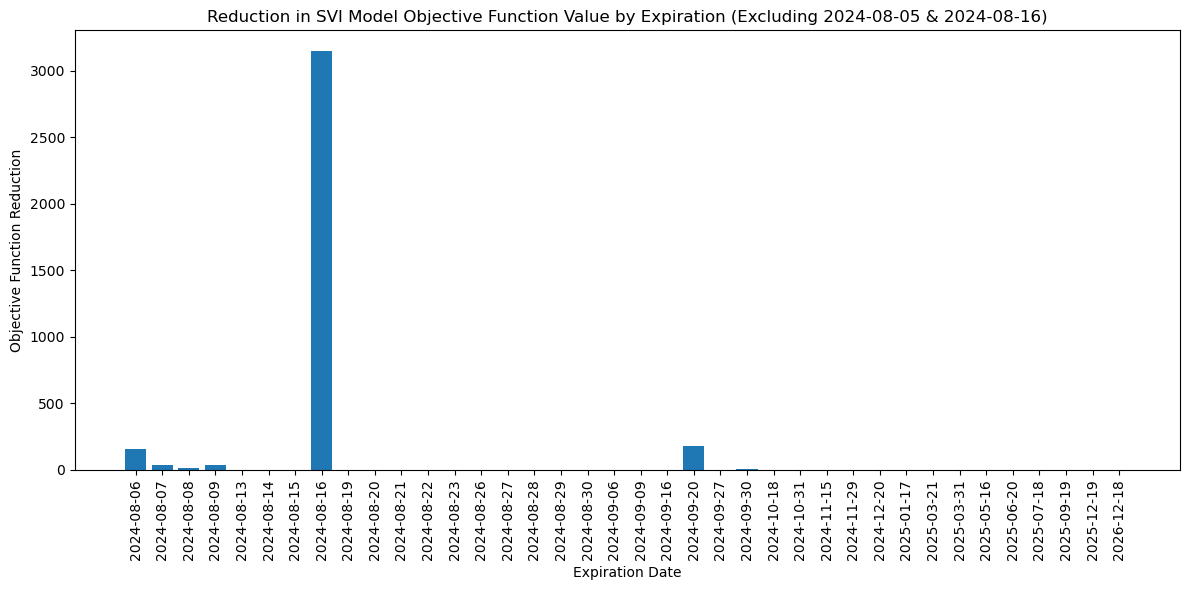

In [9]:
# Step 10: Filter out expiration dates for August 5 and August 16
filtered_df = objective_df[~objective_df['expiration'].isin(['2024-08-05'])]

# Step 11: Visualize objective function values before and after optimization (excluding August 5 and August 16)
plt.figure(figsize=(12, 6))
plt.plot(filtered_df['expiration'], filtered_df['initial_objective'], label='Initial Parameter Objective Value', marker='o', linestyle='--')
plt.plot(filtered_df['expiration'], filtered_df['optimized_objective'], label='Optimized Parameter Objective Value', marker='o', linestyle='-')
plt.xticks(rotation=90)
plt.xlabel('Expiration Date')
plt.ylabel('Objective Function Value')
plt.title('SVI Model Objective Function Value Comparison by Expiration (Excluding 2024-08-05 & 2024-08-16)')
plt.legend()
plt.tight_layout()
plt.show()

# Step 12: Visualize the reduction in objective function value (excluding August 5 and August 16)
plt.figure(figsize=(12, 6))
plt.bar(filtered_df['expiration'].astype(str), filtered_df['reduction'])
plt.xticks(rotation=90)
plt.xlabel('Expiration Date')
plt.ylabel('Objective Function Reduction')
plt.title('Reduction in SVI Model Objective Function Value by Expiration (Excluding 2024-08-05 & 2024-08-16)')
plt.tight_layout()
plt.show()


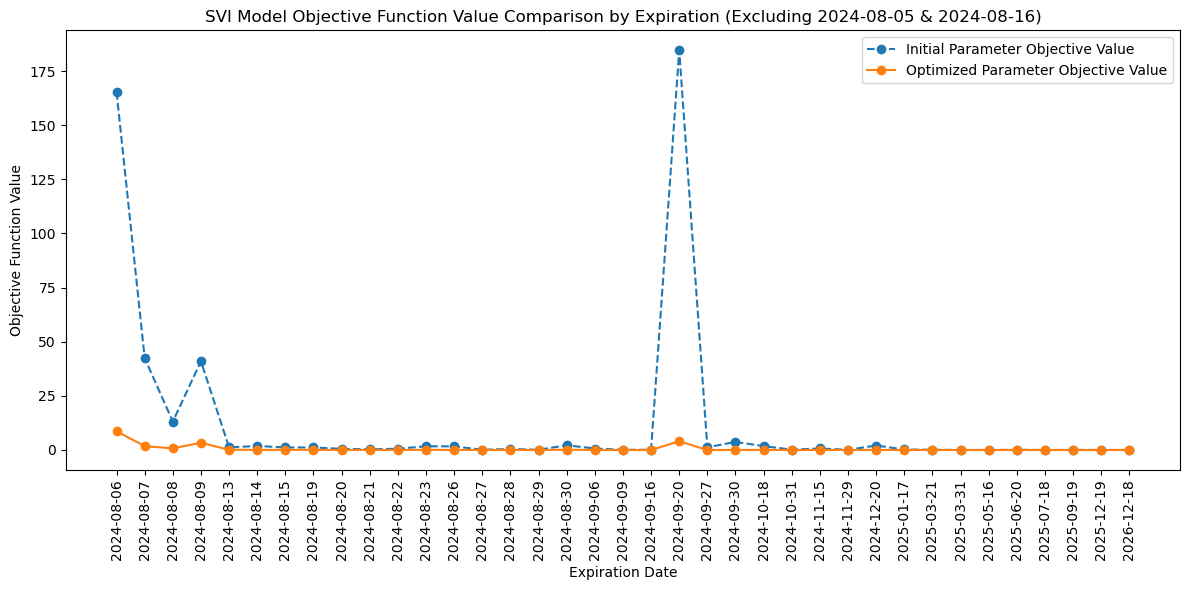

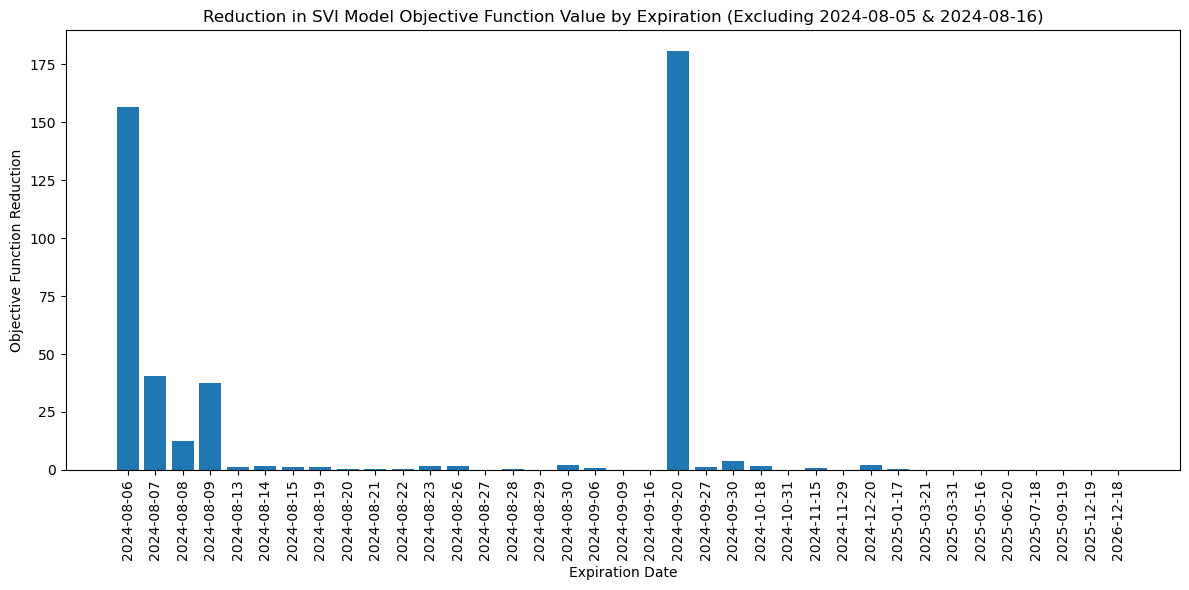

In [10]:
# Step 10: Filter out expiration dates for August 5 and August 16
filtered_df = objective_df[~objective_df['expiration'].isin(['2024-08-05', '2024-08-16'])]

# Step 11: Visualize objective function values before and after optimization (excluding August 5 and August 16)
plt.figure(figsize=(12, 6))
plt.plot(filtered_df['expiration'], filtered_df['initial_objective'], label='Initial Parameter Objective Value', marker='o', linestyle='--')
plt.plot(filtered_df['expiration'], filtered_df['optimized_objective'], label='Optimized Parameter Objective Value', marker='o', linestyle='-')
plt.xticks(rotation=90)
plt.xlabel('Expiration Date')
plt.ylabel('Objective Function Value')
plt.title('SVI Model Objective Function Value Comparison by Expiration (Excluding 2024-08-05 & 2024-08-16)')
plt.legend()
plt.tight_layout()
plt.show()

# Step 12: Visualize the reduction in objective function value (excluding August 5 and August 16)
plt.figure(figsize=(12, 6))
plt.bar(filtered_df['expiration'].astype(str), filtered_df['reduction'])
plt.xticks(rotation=90)
plt.xlabel('Expiration Date')
plt.ylabel('Objective Function Reduction')
plt.title('Reduction in SVI Model Objective Function Value by Expiration (Excluding 2024-08-05 & 2024-08-16)')
plt.tight_layout()
plt.show()


In [11]:
# SVI 모델 함수 정의
def svi_model(k, a, b, rho, m, sigma):
    return a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma**2))

# 목적 함수 정의
def objective_function(params, k, w_actual):
    a, b, rho, m, sigma = params
    w_pred = svi_model(k, a, b, rho, m, sigma)
    return np.sum((w_pred - w_actual) ** 2)

# Butterfly Arbitrage 체크 함수
def butterfly_arbitrage_check(params, k_values):
    a, b, rho, m, sigma = params
    w_k = svi_model(k_values, a, b, rho, m, sigma)
    second_derivative = np.gradient(np.gradient(w_k, k_values), k_values)
    arbitrage_free = np.all(second_derivative >= 0)
    return arbitrage_free

# Calendar Spread Arbitrage 조건을 만기일 쌍별로 확인하는 함수
def calendar_spread_arbitrage_check_per_pair(optimized_parameter, k_values):
    variances_by_expiration = {}
    for _, row in optimized_parameter.iterrows():
        expiration = row['Expiration']
        params = row[['a', 'b', 'rho', 'm', 'sigma']].values
        w_k = svi_model(k_values, *params)
        variances_by_expiration[expiration] = w_k

    sorted_expirations = sorted(variances_by_expiration.keys())

    calendar_results = []
    for i in range(len(sorted_expirations) - 1):
        T1 = sorted_expirations[i]
        T2 = sorted_expirations[i + 1]
        arbitrage_free = np.all(variances_by_expiration[T1] <= variances_by_expiration[T2])
        calendar_results.append({'Expiration Pair': (T1, T2), 'Arbitrage Free': arbitrage_free})

    return pd.DataFrame(calendar_results)

# 최적화 함수
def optimize_svi_params(data_call, initial_params, bounds, k_values):
    expiration_dates = data_call['expiration'].unique()
    optimized_parameter_adjusted = []

    for i, expiration in enumerate(expiration_dates):
        subset = data_call[data_call['expiration'] == expiration]
        k = subset['log_strike'].values
        w_actual = subset['w_actual'].values
        
        if i > 0:
            previous_params = optimized_parameter_adjusted[-1][1:]
            previous_variance = svi_model(k_values, *previous_params)
        else:
            previous_variance = None
        
        if previous_variance is not None:
            calendar_constraint = lambda params: svi_model(k_values, *params) - previous_variance
            constraints = [{'type': 'ineq', 'fun': calendar_constraint}]
        else:
            constraints = []

        def rho_constraint(params):
            _, _, rho, _, _ = params
            return 1 - abs(rho)
        
        constraints.append({'type': 'ineq', 'fun': rho_constraint})
        
        result = minimize(objective_function, initial_params, args=(k, w_actual),
                          method='L-BFGS-B', bounds=bounds, constraints=constraints)
        
        optimized_parameter_adjusted.append([expiration] + list(result.x))

    return pd.DataFrame(optimized_parameter_adjusted, columns=['Expiration', 'a', 'b', 'rho', 'm', 'sigma'])

# 두 가지 Arbitrage 조건을 테스트하고 결과를 출력하는 함수
def test_arbitrage_conditions(data_call, initial_params, bounds, k_values):
    # 파라미터 최적화
    optimized_params_df = optimize_svi_params(data_call, initial_params, bounds, k_values)
    
    # Butterfly Arbitrage 체크
    butterfly_results = []
    for _, row in optimized_params_df.iterrows():
        expiration = row['Expiration']
        params = row[['a', 'b', 'rho', 'm', 'sigma']].values
        arbitrage_free = butterfly_arbitrage_check(params, k_values)
        butterfly_results.append({'Expiration': expiration, 'Arbitrage Free': arbitrage_free})
    
    butterfly_df = pd.DataFrame(butterfly_results)
    
    # Calendar Spread Arbitrage 체크
    calendar_df = calendar_spread_arbitrage_check_per_pair(optimized_params_df, k_values)

    # Butterfly Arbitrage 충족되지 않은 개수 계산
    butterfly_violations = butterfly_df[~butterfly_df['Arbitrage Free']].shape[0]
    
    # Calendar Spread Arbitrage 충족되지 않은 개수 계산
    calendar_violations = calendar_df[~calendar_df['Arbitrage Free']].shape[0]

    # 결과 출력
    print("\nButterfly Arbitrage Check by Expiration:")
    print(butterfly_df)

    print("\nCalendar Spread Arbitrage Check by Expiration Pairs:")
    print(calendar_df)
    
    print(f"\nNumber of Expirations Not Satisfying Butterfly Arbitrage: {butterfly_violations}")
    print(f"Number of Expiration Pairs Not Satisfying Calendar Spread Arbitrage: {calendar_violations}")
    
    return butterfly_df, calendar_df, butterfly_violations, calendar_violations

# 사용자로부터 파라미터 값 입력 받기
param_string = input("Enter initial SVI parameters as a comma-separated list:\n")

# 입력된 문자열을 리스트로 변환
initial_params = [float(param.strip()) for param in param_string.split(",")]


#initial_params = [a, b, rho, m, sigma]

# 파라미터 경계 설정
bounds = [(None, None), (0, None), (-1, 1), (None, None), (0, None)]  # 파라미터 경계
k_values = np.linspace(-1, 1, 100)  # log-moneyness 범위

# 데이터 준비 (data_call은 'expiration', 'log_strike', 'w_actual'이 있는 DataFrame이어야 함)

# 두 가지 Arbitrage 조건 테스트 실행
butterfly_df, calendar_df, butterfly_violations, calendar_violations = test_arbitrage_conditions(
    data_call, initial_params, bounds, k_values)


/Users/justhaji/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:565: RuntimeWarning: Method L-BFGS-B cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,



Butterfly Arbitrage Check by Expiration:
    Expiration  Arbitrage Free
0   2024-08-05            True
1   2024-08-06            True
2   2024-08-07            True
3   2024-08-08            True
4   2024-08-09            True
5   2024-08-13            True
6   2024-08-14            True
7   2024-08-15            True
8   2024-08-16            True
9   2024-08-19            True
10  2024-08-20            True
11  2024-08-21            True
12  2024-08-22            True
13  2024-08-23            True
14  2024-08-26            True
15  2024-08-27            True
16  2024-08-28            True
17  2024-08-29            True
18  2024-08-30            True
19  2024-09-06            True
20  2024-09-09            True
21  2024-09-16            True
22  2024-09-20            True
23  2024-09-27            True
24  2024-09-30            True
25  2024-10-18            True
26  2024-10-31            True
27  2024-11-15            True
28  2024-11-29            True
29  2024-12-20            Tr

In [12]:
from datetime import datetime

# 최적화된 파라미터로부터 각 옵션의 이론적 가격 계산 및 정확도 평가 (수정)
def evaluate_option_pricing_accuracy(data_call, optimized_parameter, k_values, S, r):
    # 결과 저장을 위한 리스트
    results = []

    # 8월 5일을 현재 날짜로 설정 (모든 거래일이 이 날이므로)
    current_date = datetime(2024, 8, 5)

    # 만기일별로 데이터 및 최적화된 파라미터 추출
    for _, row in optimized_parameter.iterrows():
        expiration = row['Expiration']
        a, b, rho, m, sigma = row[['a', 'b', 'rho', 'm', 'sigma']].values
        
        # 해당 만기일 데이터 추출
        subset = data_call[data_call['expiration'] == expiration]
        strikes = subset['strike'].values  # 행사가격
        option_types = subset['option_type'].values  # 옵션 타입 ('call' 또는 'put')
        market_prices = subset['close'].values  # 실제 시장 가격 (예시로 종가 사용)
        
        # time_to_maturity 계산 (잔존기간: 만기일까지 남은 일 수를 연 단위로 변환)
        subset['expiration'] = pd.to_datetime(subset['expiration'])
        time_to_maturity = (subset['expiration'] - current_date).dt.days / 365

        # 최적화된 SVI 파라미터로 내재 변동성 계산
        log_strikes = subset['log_strike'].values
        implied_variances = svi_model(log_strikes, a, b, rho, m, sigma)
        implied_volatilities = np.sqrt(implied_variances)
        
        # 각 옵션의 이론적 가격 계산
        model_prices = []
        for i in range(len(strikes)):
            model_price = black_scholes_price(S, strikes[i], time_to_maturity.values[i], r, implied_volatilities[i], option_types[i])
            model_prices.append(model_price)
        
        # RMSE 계산
        rmse = calculate_rmse(market_prices, model_prices)
        results.append({'Expiration': expiration, 'RMSE': rmse})
    
    # 결과 DataFrame 생성 및 출력
    rmse_df = pd.DataFrame(results)
    print("\nRMSE of Option Pricing for Each Expiration:")
    print(rmse_df)
    
    return rmse_df


In [13]:
rmse_df

,Expiration,RMSE
0,2024-08-05,0.240940
1,2024-08-06,0.038936
2,2024-08-07,0.031144
3,2024-08-08,0.031850
4,2024-08-09,0.034022
5,2024-08-13,0.028135
6,2024-08-14,0.021789
7,2024-08-15,0.022207
8,2024-08-16,0.032884
9,2024-08-19,0.020926


In [14]:
from scipy.stats import norm

# 예시 무위험이자율 설정
r = 0.05

# SVI 모델 함수 정의 (예시로 주어진 구조)
def svi_model(k, a, b, rho, m, sigma):
    return a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma**2))

# SVI 파라미터 최적화 함수 정의 (만기일별로 파라미터를 최적화)
def optimize_svi_params(data_call):
    expiration_dates = data_call['expiration'].unique()
    optimized_params = []

    for expiration in expiration_dates:
        subset = data_call[data_call['expiration'] == expiration]
        log_strikes = subset['log_strike'].values
        implied_vol = subset['implied_volatility'].values

        # 초기 파라미터 추정 (예시 값)
        initial_params = [0, 0.1, 0, 0, 0.1]

        # 목적 함수 정의 (예: 실제 내재 변동성과 모델 변동성의 차이 최소화)
        def objective_function(params):
            a, b, rho, m, sigma = params
            model_variance = svi_model(log_strikes, a, b, rho, m, sigma)
            return np.sum((model_variance - implied_vol**2) ** 2)

        # 파라미터 경계 설정
        bounds = [(None, None), (0, None), (-1, 1), (None, None), (0, None)]

        # 최적화 실행
        result = minimize(objective_function, initial_params, bounds=bounds)
        optimized_params.append([expiration] + list(result.x))

    return pd.DataFrame(optimized_params, columns=['Expiration', 'a', 'b', 'rho', 'm', 'sigma'])

# 최적화된 파라미터 생성
optimized_params_df = optimize_svi_params(data_call)

# SVI 최적화 후 RMSE 계산 함수 (최적화된 파라미터로 각 옵션 가격의 정확도를 평가)
optimized_rmse_df = evaluate_option_pricing_accuracy(data_call, optimized_params_df, r)

# 기존 RMSE 데이터 (예시로 모든 만기일에 대한 기존 RMSE가 10으로 설정되어 있음)
# 실제 데이터에 맞게 RMSE 값 수정 필요
initial_rmse_data = [
    {'Expiration': exp, 'RMSE': 10.0} for exp in optimized_rmse_df['Expiration'].tolist()
]
initial_rmse_df = pd.DataFrame(initial_rmse_data)

# RMSE 비교 시각화 함수 정의
def plot_rmse_comparison(initial_rmse_df, optimized_rmse_df):
    # 만기일 기준 정렬
    initial_rmse_df = initial_rmse_df.sort_values(by='Expiration')
    optimized_rmse_df = optimized_rmse_df.sort_values(by='Expiration')
    
    # 만기일
    expirations = initial_rmse_df['Expiration'].astype(str).tolist()
    
    # 기존 RMSE와 최적화된 RMSE
    initial_rmse = initial_rmse_df['RMSE'].values
    optimized_rmse = optimized_rmse_df['RMSE'].values

    # 그래프 그리기
    plt.figure(figsize=(12, 6))
    bar_width = 0.35  # 막대 너비
    index = np.arange(len(expirations))

    # 기존 RMSE 막대
    plt.bar(index, initial_rmse, bar_width, label='Initial RMSE', color='red', alpha=0.6)
    # 최적화된 RMSE 막대
    plt.bar(index + bar_width, optimized_rmse, bar_width, label='Optimized RMSE', color='blue', alpha=0.6)

    # 그래프 설정
    plt.xlabel('Expiration Date')
    plt.ylabel('RMSE')
    plt.title('Comparison of Option Pricing RMSE Before and After SVI Optimization')
    plt.xticks(index + bar_width / 2, expirations, rotation=90)
    plt.legend()
    plt.tight_layout()

    # 그래프 출력
    plt.show()

# 시각화 실행
plot_rmse_comparison(initial_rmse_df, optimized_rmse_df)


TypeError: evaluate_option_pricing_accuracy() missing 2 required positional arguments: 'S' and 'r'